In [1]:
#Distributions and Modules
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import distributions
import pandas as pd
import numpy as np
from torch import optim

In [2]:
gamma = 0.9

In [3]:
def Normalization(df):
    df.iloc[:,2:]= df.iloc[:,2:].apply(lambda x: ((x-x.mean()) / (x.std())))
    return df

In [4]:
def preprocessing(path):
    df = pd.read_csv(path, header=None, delimiter=' ')
    
    #Normalize the data
    df = Normalization(df)
    
    #Drop the columns which has all values as Nan
    df.dropna(axis=1, how='all', inplace=True)
    
    #Get Rewards for each time step : 0 except last time step where reward is -100
    df['Counter'] = df.index
    lastRowIndex = df.groupby(0).last().Counter.tolist()
    df['reward'] = df['Counter'].apply(lambda x : -100 if x in lastRowIndex else 0 )
    df.drop(columns=['Counter'],inplace=True)
    
    #Rename columns
    df.rename(columns={0: "machine", 1: "time"}, inplace=True)
    
    #Calculate Monte Carlo Value for each row
    df1 = df.groupby('machine').last()[['time']].reset_index()
    df = pd.merge(df, df1, on = 'machine', how = 'left').rename(columns ={'time_x':'time','time_y':'lastTimeStamp'})
    df['MC_Val'] = (gamma ** (df['lastTimeStamp'] - df['time'] )) * (-100)
    df = df.drop(columns='lastTimeStamp')
    
    return df

In [29]:
df = preprocessing("/home/abc/Berkeley/Prof_Ram/CMAPSSData/train_FD001.txt")

## We have added the reward and Val column. We will be using the Val column for the Monte Carlo return gamma**(T-t)  X  -100

## Now lets build the Neural network for the predictron

In [6]:
#Neural network for Observation - Hidden State

In [7]:
class NN_OH(nn.Module):
    def __init__(self, input_size, out_size):
        super(NN_OH,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,out_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
input_size  = 24
out_size = 4
net = NN_OH(input_size, out_size)
print(net)

NN_OH(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [9]:
#Neural network for Hidden State - Reward & Value

In [10]:
class NN_reward_val(nn.Module):
    def __init__(self, input_size):
        super(NN_reward_val,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,2)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
##Neural Network which will take my current hidden state to the next hidden state

In [12]:
class NN_HH(nn.Module):
    def __init__(self, input_size):
        super(NN_HH,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,input_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [51]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictron(nn.Module):
    def __init__(self, obs_size, hid_size, k=10):
        super(Predictron,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.fc1 = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.fc2 = NN_reward_val(hid_size)
        
        #Instantiate Neural Network for Hidden State - Next Hidden State
        self.fc3 = NN_HH(hid_size)
        
        #K-step return
        self.k = k
        
    def forward(self, x):
        #Predictron core will output the value estimate for the current observation. We will input x (observation) 
        #and get value estimate. This implementation is for a k-step return which can be extended to TD(lambda) return
        
        #First step: Get the Hidden state for the current observation
        
        x = self.fc1(x)
        
        #Now we keep track of rewards for the k-step return
        reward = self.fc2(x)[:,0].reshape(-1,1)
        #print(reward.shape)
        for i in range(self.k-1):
            #Take the next step
            x = self.fc3(x)
            reward += (gamma**(i+1))*(self.fc2(x)[:,0].reshape(-1,1))
        
        val_kth = (gamma**self.k)*self.fc2(self.fc3(x))[:,1].reshape(-1,1)
        
        return reward+val_kth
            
        

In [60]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictronv2(nn.Module):
    def __init__(self, obs_size, hid_size, k=10):
        super(Predictron,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.fc1 = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.fc2 = NN_reward_val(hid_size)
        
        #Instantiate Neural Network for Hidden State - Next Hidden State
        self.fc3 = NN_HH(hid_size)
        
        #K-step return
        self.k = k
        
    def forward(self, x):
        #Predictron core will output the value estimate for the current observation. We will input x (observation) 
        #and get value estimate. This implementation is for a k-step return which can be extended to TD(lambda) return
        
        #First step: Get the Hidden state for the current observation
        
        x = self.fc1(x)
        
        #Unlike v1, we want to keep track of all the k-step returns till k and then take average
        reward = self.fc2(x)[:,0].reshape(-1,1) 
        all_k_vals = torch.zeros(x.shape[1],k+1)
        all_k_vals[:,0] = reward #This will be the 0-step return
        #print(reward.shape)
        for i in range(1, self.k+1):
            #Take the next step
            x = self.fc3(x)
            reward += (gamma**(i))*(self.fc2(x)[:,0].reshape(-1,1))
            val_ith = (gamma**self.k)*self.fc2(self.fc3(x))[:,1].reshape(-1,1)
            all_k_vals[:,i] = reward + val_ith    
        
        return torch.sum(all_k_vals, axis=1)
            
        

In [52]:
def getXY(data):
    x = torch.tensor(data.iloc[:, 2:-2].values).float()
    y_target = torch.tensor(data.iloc[:,-1].values).float()
    y_target = y_target.reshape(-1,1)
    
    return x, y_target

In [53]:
x, y_target = getXY(df)

In [54]:
y_target.shape

torch.Size([20631, 1])

In [55]:
#Defining the loss function and Initialising the Predictron core
k=7
loss_fn = nn.MSELoss()
core = Predictron(x.shape[1], 4, k)
optimizer = optim.Adam(core.parameters(), lr = 1e-3) 

In [56]:
n_epochs = 30 # or whatever
batch_size = 128 # or whatever
losses=[]
for epoch in range(n_epochs):

    # x is our input
    permutation = torch.randperm(x.size()[0])

    for i in range(0,x.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x[indices], y_target[indices]

        # in case you wanted a semi-full example
        outputs = core.forward(batch_x)
        loss = loss_fn(outputs,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Loss after:"+str(epoch)+" iterations is :"+ str(loss))

Loss after:0 iterations is :tensor(101.7529, grad_fn=<MseLossBackward>)
Loss after:1 iterations is :tensor(30.3507, grad_fn=<MseLossBackward>)
Loss after:2 iterations is :tensor(27.3663, grad_fn=<MseLossBackward>)
Loss after:3 iterations is :tensor(40.7365, grad_fn=<MseLossBackward>)
Loss after:4 iterations is :tensor(22.3529, grad_fn=<MseLossBackward>)
Loss after:5 iterations is :tensor(39.9035, grad_fn=<MseLossBackward>)
Loss after:6 iterations is :tensor(30.8898, grad_fn=<MseLossBackward>)
Loss after:7 iterations is :tensor(26.3040, grad_fn=<MseLossBackward>)
Loss after:8 iterations is :tensor(0.5342, grad_fn=<MseLossBackward>)
Loss after:9 iterations is :tensor(12.4923, grad_fn=<MseLossBackward>)
Loss after:10 iterations is :tensor(15.9527, grad_fn=<MseLossBackward>)
Loss after:11 iterations is :tensor(5.5713, grad_fn=<MseLossBackward>)
Loss after:12 iterations is :tensor(18.5324, grad_fn=<MseLossBackward>)
Loss after:13 iterations is :tensor(19.0178, grad_fn=<MseLossBackward>)
Los

Text(0.5, 1.0, 'Training Loss for Predictron with 7-step return')

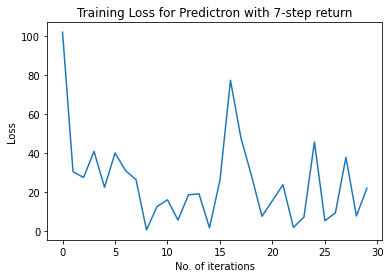

In [59]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")
plt.title("Training Loss for Predictron with "+str(k)+"-step return")

In [23]:
for p in core.parameters():
    print(p.shape)

torch.Size([64, 21])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])
torch.Size([32, 4])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([2, 16])
torch.Size([2])
torch.Size([32, 4])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([4, 32])
torch.Size([4])


## Testing

In [30]:
df_test = preprocessing("/home/abc/Berkeley/Prof_Ram/CMAPSSData/test_FD001.txt")

In [35]:
x_test, y_test = getXY(df_test)

In [36]:
x_test.shape

torch.Size([13096, 21])

In [37]:
y_test.shape

torch.Size([13096, 1])

In [38]:
predict_test = core.forward(x_test)

In [43]:
loss_fn(predict_test, y_test)

tensor(336.5748, grad_fn=<MseLossBackward>)